In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
import seaborn as sns
import re
from convex_optimization_deriving_results import Network, Investors, Consumers, Example_Anaheim, Example, Example_6node, Example_3node
from Transportaion_test_systems import import_matrix, transportation_network_topo
import math

In [4]:
def getNumbers(str):
    array = re.findall(r'[0-9]+', str)
    return array

### Loading network parameters

In [5]:
congestion = False 
identical_scen = False 
Ntw = Example(identical_scen, congestion)
Ntw.C.b3

growth at scen  1 :  1.0268728488224803
growth at scen  2 :  1.1694867473874464
growth at scen  3 :  1.1527549237953227
growth at scen  4 :  1.0510138051478843
growth at scen  5 :  1.0990870174183882
growth at scen  6 :  1.0898982129577477
growth at scen  7 :  1.1303185945445526
growth at scen  8 :  1.1577446702271026
growth at scen  9 :  1.018771917354847
growth at scen  10 :  1.0056694953044012
growth at scen  11 :  1.167153020783974
growth at scen  12 :  1.0865534135810107
growth at scen  13 :  1.1524560164915885
growth at scen  14 :  1.0004212106702222
growth at scen  15 :  1.0890774388109603
growth at scen  16 :  1.1443080064681566
growth at scen  17 :  1.0457524442540904
growth at scen  18 :  1.1890541391107845
growth at scen  19 :  1.1802854915222967
growth at scen  20 :  1.0061179966067106


0.06

In [6]:
Ntw.C.b1

1

### Adding results paths

In [7]:
root = (os.getcwd())
results_path = root + '/Results'
directory_contents = sorted(os.listdir(results_path))
results_folders=[]
# for item in directory_contents:
#     if os.path.isdir(item):
# #         print(getNumbers(item))
#         results_folders.append(item)
        
final_results_path = os.path.join(results_path, directory_contents[-1])
# final_results_path = os.path.join(results_path, 'Results_20211121_1648')
determenistic_result_directory = os.path.dirname(os.getcwd()) + '/script_v8_deterministic_speed_up'

In [8]:
# directory_contents

### Figures setup

In [9]:
from collections import namedtuple, OrderedDict
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (9, 6)
mpl.rcParams['axes.grid'] = False
mpl.rcParams['lines.linewidth'] = 2
 
mpl.rc('font',family='Times New Roman', size=20)
fnt_size=30
fnt_size2=20
csfont = {'fontname':'Times New Roman',
                  'size': fnt_size,
                 'fontweight':'bold'}
csfont2 = {'fontname':'Times New Roman',
                  'size': fnt_size2}

Color = namedtuple('RGB','red, green, blue')
class RGB(Color):
    def hex_format(self):
        return '#{:02X}{:02X}{:02X}'.format(self.red,self.green,self.blue)

### Helper functions for reading results

In [10]:
def data_reader(file_name, result_type):
    
    
    scenarios = []
    nodes = []
    value = []
    value_dict={}
    with open(file_name, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            while("" in row):
                row.remove("")
#         row_numbers = getNumbers(row)
            scenarios.append(int(getNumbers(row[0])[0]))
            nodes.append(int(getNumbers(row[1])[0]))
            value.append(float(row[-1]))
            if result_type == 'stochastic':
                value_dict[int(getNumbers(row[1])[0]), int(getNumbers(row[0])[0])] = float(row[-1])
            elif result_type == 'deterministic':
                value_dict[int(getNumbers(row[1])[0])] = float(row[-1])
            
    value_stochastic_dict= {'Nodes':nodes, 'Scenarios':scenarios, 'Values':value}
    value_stochastic_df = pd.DataFrame(value_stochastic_dict)
            
    return value_stochastic_df, value_dict

def traffic_data_reader(file_name, traffic_type):
    
    if traffic_type == 'q':
        q={}
        with open(file_name, 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                while("" in row):
                    row.remove("")
                if float(row[-1]) == 0:
                    q[int(getNumbers(row[1])[0]), int(getNumbers(row[2])[0]), int(getNumbers(row[3])[0]), int(getNumbers(row[0])[0])] = float(row[-1]) + 0.00001
                else:
                    q[int(getNumbers(row[1])[0]), int(getNumbers(row[2])[0]), int(getNumbers(row[3])[0]), int(getNumbers(row[0])[0])] = float(row[-1])
        return q
    
    elif traffic_type == 'x':
        x={}
        with open(file_name, 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                while("" in row):
                    row.remove("")
                x[int(getNumbers(row[1])[0]), int(getNumbers(row[2])[0]), int(getNumbers(row[3])[0]), int(getNumbers(row[4])[0]), int(getNumbers(row[5])[0]), int(getNumbers(row[0])[0])] = float(row[-1])
        return x
    
    elif traffic_type == 'lamda':
        lamda={}
        with open(file_name, 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                while("" in row):
                    row.remove("")
                lamda[int(getNumbers(row[1])[0]), int(getNumbers(row[2])[0]), int(getNumbers(row[3])[0]), int(getNumbers(row[4])[0]), int(getNumbers(row[0])[0])] = float(row[-1])
        return lamda
    elif traffic_type == 'mu':
        mu={}
        with open(file_name, 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                while("" in row):
                    row.remove("")
                mu[int(getNumbers(row[1])[0]), int(getNumbers(row[2])[0]), int(getNumbers(row[0])[0])] = float(row[-1])
        return mu
    
    else:
        print('Invalid traffic type; valid options are: q, x, lamda, mu')

# Prices

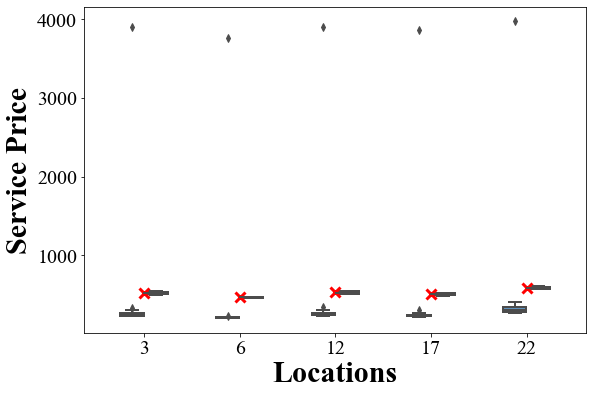

In [11]:
price_file_stochastic = os.path.join(final_results_path, 'Resulting_prices_with_anti.csv')
price_file_stochastic_wo_anti = os.path.join(final_results_path, 'Resulting_prices_with_no_anti.csv')
price_file_deterministic = os.path.join(determenistic_result_directory, 'Results_prices.csv')


prices_stochastic_df, rho_stochastic = data_reader(file_name=price_file_stochastic,result_type='stochastic')

prices_stochastic_wo_anti_df, rho_stochastic_wo_anti = data_reader(file_name=price_file_stochastic_wo_anti,result_type='stochastic')

combined_prices_df = pd.DataFrame()
combined_prices_df['Nodes'] = list(prices_stochastic_df.Nodes) + list(prices_stochastic_wo_anti_df.Nodes)
combined_prices_df['Scenarios'] = list(prices_stochastic_df.Scenarios) + list(prices_stochastic_wo_anti_df.Scenarios)
combined_prices_df['Values'] = list(prices_stochastic_df.Values) + list(prices_stochastic_wo_anti_df.Values)
combined_prices_df['Types'] = ['With anti']*len(prices_stochastic_df.Nodes) + ['WO anti']*len(prices_stochastic_wo_anti_df.Nodes)


prices_deterministic_df, rho_deterministic = data_reader(file_name=price_file_deterministic,result_type='deterministic')

fig, ax = plt.subplots()
my_pal = {"With anti": RGB(79/255,148/255,205/255), "WO anti": RGB(255/255,128/255,0)}
ax = sns.boxplot(x='Nodes', y='Values', data=combined_prices_df, hue='Types', linewidth=2, width=0.5, palette = my_pal)
ax.scatter(range(len(prices_deterministic_df.Nodes)),prices_deterministic_df.Values, linewidth=3, marker='x', color='red', s=100)
ax.set_xlabel("Locations",**csfont)
ax.set_ylabel("Service Price",**csfont);
# legend = plt.legend(fontsize=20, frameon=False);
ax.get_legend().remove()
# legend = plt.legend(loc='best', bbox_to_anchor=(0.6, 0.5, 0, 0) ,ncol=2, title='Nodes',fontsize=20, frameon=False)
plt.savefig('./Figures/rho.png',dpi=500, format='png', bbox_inches='tight')

In [12]:
prices_deterministic_df

,Nodes,Scenarios,Values
0,3,1,519.264277
1,6,1,463.033659
2,12,1,526.263923
3,17,1,505.682305
4,22,1,586.810313


# Services (g)

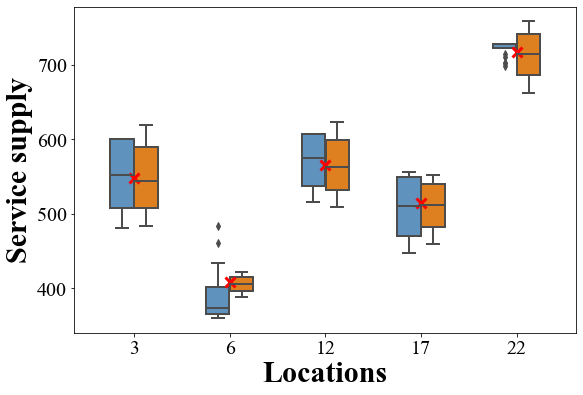

In [10]:
service_file_stochastic = os.path.join(final_results_path, 'Resulting_services_with_anti.csv')
service_file_stochastic_wo_anti = os.path.join(final_results_path, 'Resulting_services_with_no_anti.csv')
service_file_deterministic = os.path.join(determenistic_result_directory, 'Results_services.csv')


services_df_stochastic, g_stochastic = data_reader(file_name=service_file_stochastic,result_type='stochastic')
services_df_stochastic_wo_anti, g_stochastic_wo_anti = data_reader(file_name=service_file_stochastic_wo_anti,result_type='stochastic')
combined_services_df = pd.DataFrame()
combined_services_df['Nodes'] = list(services_df_stochastic.Nodes) + list(services_df_stochastic_wo_anti.Nodes)
combined_services_df['Scenarios'] = list(services_df_stochastic.Scenarios) + list(services_df_stochastic_wo_anti.Scenarios)
combined_services_df['Values'] = list(services_df_stochastic.Values) + list(services_df_stochastic_wo_anti.Values)
combined_services_df['Types'] = ['With anti']*len(services_df_stochastic.Nodes) + ['WO anti']*len(services_df_stochastic_wo_anti.Nodes)

services_df_deterministic, g_deterministic = data_reader(file_name=service_file_deterministic,result_type='deterministic') 

fig, ax = plt.subplots()
ax = sns.boxplot(x='Nodes', y='Values', data=combined_services_df, hue='Types', linewidth=2, width=0.5, palette = my_pal)
ax.scatter(range(len(services_df_deterministic.Nodes)), services_df_deterministic.Values, linewidth=3, color='red', marker ='x', s=100)
# ax.set_ylim(480,800)
ax.set_xlabel("Locations",**csfont)
ax.set_ylabel("Service supply",**csfont);
legend = plt.legend(loc='upper left',  title='Types',fontsize=20, frameon=False);
ax.get_legend().remove()
# legend = plt.legend(loc='best', bbox_to_anchor=(0.6, 0.5, 0, 0) ,ncol=2, title='Nodes',fontsize=20, frameon=False)
plt.savefig('./Figures/g.png',dpi=500, format='png', bbox_inches='tight')

# Capacity

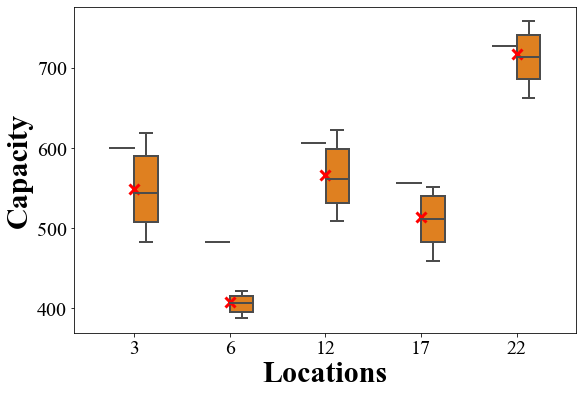

In [11]:
capacities_file_stochastic = os.path.join(final_results_path, 'Resulting_capacities_with_anti.csv')
capacities_file_stochastic_wo_anti = os.path.join(final_results_path, 'Resulting_capacities_with_no_anti.csv')
capacity_file_deterministic = os.path.join(determenistic_result_directory, 'Results_capacity.csv')

capacity_df_stochastic, c_stochastic = data_reader(file_name=capacities_file_stochastic,result_type='stochastic')
capacity_df_stochastic_wo_anti, c_stochastic_wo_anti = data_reader(file_name=capacities_file_stochastic_wo_anti,result_type='stochastic')
combined_capacity_df = pd.DataFrame()
combined_capacity_df['Nodes'] = list(capacity_df_stochastic.Nodes) + list(capacity_df_stochastic_wo_anti.Nodes)
combined_capacity_df['Scenarios'] = list(capacity_df_stochastic.Scenarios) + list(capacity_df_stochastic_wo_anti.Scenarios)
combined_capacity_df['Values'] = list(capacity_df_stochastic.Values) + list(capacity_df_stochastic_wo_anti.Values)
combined_capacity_df['Types'] = ['With anti']*len(capacity_df_stochastic.Nodes) + ['WO anti']*len(capacity_df_stochastic_wo_anti.Nodes)


capacity_df_deterministic, c_deterministic = data_reader(file_name=capacity_file_deterministic,result_type='deterministic')


fig, ax = plt.subplots()
ax = sns.boxplot(x='Nodes', y='Values', data=combined_capacity_df, hue= 'Types', linewidth=2, width=0.5, palette = my_pal)
ax.scatter(range(len(capacity_df_deterministic.Nodes)), capacity_df_deterministic.Values, linewidth=3, color='red', marker ='x', s=100)
ax.set_xlabel("Locations",**csfont)
ax.set_ylabel("Capacity",**csfont);
legend = plt.legend(fontsize=20, frameon=False);
ax.get_legend().remove()
plt.savefig('./Figures/c.png',dpi=500, format='png', bbox_inches='tight')

# Traffic

In [12]:
Traffic_file_stochastic = os.path.join(final_results_path, 'Resulting_traffic_with_anti.csv')
Traffic_file_stochastic_wo_anti = os.path.join(final_results_path, 'Resulting_traffic_with_no_anti.csv')
# Traffic_file_deterministic = os.path.join(determenistic_result_directory, 'Results_traffic.csv')

q_stochastic = traffic_data_reader(Traffic_file_stochastic,'q')
q_stochastic_wo_anti = traffic_data_reader(Traffic_file_stochastic_wo_anti,'q')
# q_deterministic = traffic_data_reader(Traffic_file_deterministic,'q')

Link_Traffic_file_stochastic = os.path.join(final_results_path, 'Resulting_link_traffic_with_anti.csv')
Link_Traffic_file_stochastic_wo_anti = os.path.join(final_results_path, 'Resulting_link_traffic_with_no_anti.csv')

x_stochastic = traffic_data_reader(Link_Traffic_file_stochastic, 'x')
x_stochastic_wo_anti = traffic_data_reader(Link_Traffic_file_stochastic_wo_anti, 'x')

lamda1_file_stochastic = os.path.join(final_results_path, 'Resulting_lamda1_with_anti.csv')
lamda1_file_stochastic_wo_anti = os.path.join(final_results_path, 'Resulting_lamda1_with_no_anti.csv')

lamda1_stochastic = traffic_data_reader(lamda1_file_stochastic, 'lamda')
lamda1_stochastic_wo_anti = traffic_data_reader(lamda1_file_stochastic, 'lamda')

lamda2_file_stochastic = os.path.join(final_results_path, 'Resulting_lamda2_with_anti.csv')
lamda2_file_stochastic_wo_anti = os.path.join(final_results_path, 'Resulting_lamda2_with_no_anti.csv')

lamda2_stochastic = traffic_data_reader(lamda2_file_stochastic, 'lamda')
lamda2_stochastic_wo_anti = traffic_data_reader(lamda2_file_stochastic, 'lamda')

mu_stochastic = traffic_data_reader(lamda2_file_stochastic, 'mu')
mu_stochastic_wo_anti = traffic_data_reader(lamda2_file_stochastic, 'mu')

# Surpluss analysis

### Investors cost calculation

In [13]:
Investors_total_cost = sum (Ntw.Scn.pr[u] *(
    (Ntw.I.ca*c_stochastic[k,u]**2 + Ntw.I.cb*c_stochastic[k,u]) +
    (Ntw.I.ga*g_stochastic[k,u]**2+Ntw.I.gb*g_stochastic[k,u])) for k in Ntw.I.K for u in Ntw.Scn.U)

Investors_total_cost_wo_anti = sum (Ntw.Scn.pr[u] *(
    (Ntw.I.ca*c_stochastic_wo_anti[k,u]**2 + Ntw.I.cb*c_stochastic_wo_anti[k,u]) +
    (Ntw.I.ga*g_stochastic_wo_anti[k,u]**2+Ntw.I.gb*g_stochastic_wo_anti[k,u])) for k in Ntw.I.K for u in Ntw.Scn.U)
print('Investors costs       With non-anti      WO non-anti')
print('                     ', round(Investors_total_cost,4), '     ', round(Investors_total_cost_wo_anti,4))

Investors costs       With non-anti      WO non-anti
                      1200865.3238       1140071.4525


### Investors objective calculation

In [14]:
Investors_objective = sum(Ntw.Scn.pr[u] *( 
    rho_stochastic[k,u]*g_stochastic[k,u] -
        (Ntw.I.ca*c_stochastic[k,u]**2 + Ntw.I.cb*c_stochastic[k,u]) - 
        (Ntw.I.ga*g_stochastic[k,u]**2+Ntw.I.gb*g_stochastic[k,u])) for k in Ntw.I.K for u in Ntw.Scn.U)

Investors_objective_wo_anti = sum(Ntw.Scn.pr[u] *( 
    rho_stochastic_wo_anti[k,u]*g_stochastic_wo_anti[k,u] -
        (Ntw.I.ca*c_stochastic_wo_anti[k,u]**2 + Ntw.I.cb*c_stochastic_wo_anti[k,u]) - 
        (Ntw.I.ga*g_stochastic_wo_anti[k,u]**2+Ntw.I.gb*g_stochastic_wo_anti[k,u])) for k in Ntw.I.K for u in Ntw.Scn.U)
print('Investors Obj       With non-anti      WO non-anti')
print('                   ', round(Investors_objective,5), '     ', round(Investors_objective_wo_anti,4))

Investors Obj       With non-anti      WO non-anti
                    337674.60937       314280.5943


In [15]:
Investors_objective - Investors_objective_wo_anti


23394.015058019257

### Calculating utility and ravel time based on x

In [16]:
def travel_time(Ntw,lamda1,lamda2,mu):
    t={}
    A={}
    for r in Ntw.C.R:
        for s in Ntw.C.S:
            for k in Ntw.C.K:
                for u in Ntw.Scn.U:
                    A[r,s,k,u] = lamda1[r,s,k,r,u] - lamda1[r,s,k,k,u]  + lamda2[r,s,k,k,u] - lamda2[r,s,k,s,u]
                    t[r,s,k,u] = (Ntw.C.b3/(Ntw.C.b1*Ntw.Scn.pr[u])) * A[r,s,k,u]
#                     t[r,s,k,u] = (Ntw.C.b3/Ntw.Scn.pr[u]) * (A[r,s,k,u]- mu[r,s,u])
#                     t[r,s,k,u] = sum(Ntw.C.tff[i,j] * (1+Ntw.C.b[i,j]*((x[i,j,r,s,k,u]/Ntw.C.cap[i,j])**Ntw.C.alpha[i,j])) for (i,j) in Ntw.C.A)
                    
    return t

def Utility_func(Ntw,lamda1,lamda2,mu,q,rho):
    t_time = travel_time(Ntw,lamda1,lamda2,mu)
    U={}
    for r in Ntw.C.R:
        for s in Ntw.C.S:
            for k in Ntw.C.K:
                for u in Ntw.Scn.U:
                    U[r,s,k,u] = Ntw.C.b0[k] - Ntw.C.b1 * t_time[r,s,k,u]- Ntw.C.b3*rho[k,u] * Ntw.C.e[r,s]
                    
                    
    return U

In [17]:
travel_time(Ntw,lamda1_stochastic,lamda2_stochastic,mu_stochastic)

{(2, 1, 3, 1): 28.319603844116816,
 (2, 1, 3, 2): 28.53648570735286,
 (2, 1, 3, 3): 28.54532399115927,
 (2, 1, 3, 4): 28.36164306595474,
 (2, 1, 3, 5): 28.453654092199827,
 (2, 1, 3, 6): 28.43535863217083,
 (2, 1, 3, 7): 28.516138221064047,
 (2, 1, 3, 8): 28.546124381393575,
 (2, 1, 3, 9): 28.306425318315554,
 (2, 1, 3, 10): 28.28606300180781,
 (2, 1, 3, 11): 28.53873266829447,
 (2, 1, 3, 12): 28.428780907315268,
 (2, 1, 3, 13): 28.545279517374183,
 (2, 1, 3, 14): 28.278231408776527,
 (2, 1, 3, 15): 28.43374109624235,
 (2, 1, 3, 16): 28.543018187979555,
 (2, 1, 3, 17): 28.352140928794615,
 (2, 1, 3, 18): 28.523578515717492,
 (2, 1, 3, 19): 28.52787060672467,
 (2, 1, 3, 20): 28.286740553548697,
 (2, 1, 6, 1): 40.878197447318655,
 (2, 1, 6, 2): 45.116934943024994,
 (2, 1, 6, 3): 43.38405559029952,
 (2, 1, 6, 4): 41.22350782564106,
 (2, 1, 6, 5): 42.00755247937837,
 (2, 1, 6, 6): 41.84941895175472,
 (2, 1, 6, 7): 42.50389348686964,
 (2, 1, 6, 8): 43.77262487830103,
 (2, 1, 6, 9): 40.76605

In [1]:
rho[k,u]

NameError: name 'rho' is not defined

In [18]:
Utility_stochastic = Utility_func(Ntw,lamda1_stochastic,lamda2_stochastic,mu_stochastic,q_stochastic,rho_stochastic)
Utility_stochastic_wo_anti = Utility_func(Ntw,lamda1_stochastic_wo_anti,lamda2_stochastic_wo_anti,mu_stochastic_wo_anti,q_stochastic_wo_anti,rho_stochastic_wo_anti)

total_utility = sum (Ntw.Scn.pr[u]*(Utility_stochastic[r,s,k,u] * q_stochastic[r,s,k,u]) / Ntw.C.b3 for r in Ntw.C.R for s in Ntw.C.S for k in Ntw.C.K for u in Ntw.C.Scn.U)
total_utility_wo_anti = sum (Ntw.Scn.pr[u]* (Utility_stochastic_wo_anti[r,s,k,u] * q_stochastic_wo_anti[r,s,k,u]) / Ntw.C.b3 for r in Ntw.C.R for s in Ntw.C.S for k in Ntw.C.K for u in Ntw.C.Scn.U)

In [19]:
total_utility - total_utility_wo_anti

-84225.60361948889

### Surpluss calculation

In [20]:
Surpluss_stochastic = Investors_objective + sum (Ntw.Scn.pr[u]*(Utility_stochastic[r,s,k,u] * q_stochastic[r,s,k,u]) / Ntw.C.b3 for r in Ntw.C.R for s in Ntw.C.S for k in Ntw.C.K for u in Ntw.C.Scn.U)

Surpluss_stochastic_wo_anti = Investors_objective_wo_anti + sum (Ntw.Scn.pr[u]* (Utility_stochastic_wo_anti[r,s,k,u] * q_stochastic_wo_anti[r,s,k,u]) / Ntw.C.b3 for r in Ntw.C.R for s in Ntw.C.S for k in Ntw.C.K for u in Ntw.C.Scn.U)

print('Surpluss       With non-anti      WO non-anti')
print('              ', round(Surpluss_stochastic,4), '     ', round(Surpluss_stochastic_wo_anti,4))

Surpluss       With non-anti      WO non-anti
               -3342577.5264       -3281745.9378


# EVPI analysis

## Investors

In [21]:
EVPI_investors = Investors_objective - Investors_objective_wo_anti
EVPI_investors

23394.015058019257

## Consumers 

In [22]:
def consumer_obj_func(Ntw,q,x,rho,c):
    v = {}
    for (r,s) in Ntw.C.A:
        for u in Ntw.Scn.U:
            v[r,s,u] = sum (x[r,s,i,j,k,u] for i in Ntw.C.R for j in Ntw.C.S for k in Ntw.C.K)
    
    exp0 = {}
    exp1 = {}
    
    
    for u in Ntw.Scn.U:
        
        exp0[u] = sum(Ntw.C.tff[r,s]*(v[r,s,u]+(Ntw.C.b[r,s]/(Ntw.C.alpha[r,s]+1.0))*(v[r,s,u]**(Ntw.C.alpha[r,s]+1))/(Ntw.C.cap[r,s]**(Ntw.C.alpha[r,s]))) for (r,s) in Ntw.C.A)
        exp1[u] = 1.0/Ntw.C.b1*( sum( q[r,s,k,u]*( math.log(q[r,s,k,u]) - 1.0 + Ntw.C.b3 * rho[k,u] * Ntw.C.e[r,s] - Ntw.C.b0[k]) for k in Ntw.C.K for s in Ntw.C.S for r in Ntw.C.R))
        
    consumer_obj = sum(exp0[u] + exp1[u] for u in Ntw.Scn.U) 
    
    return consumer_obj


In [23]:
for r in Ntw.C.R:
    for s in Ntw.C.S:
        for k in Ntw.C.K:
            for u in Ntw.Scn.U:
                print('(', r,s,k,u,')   ', q_stochastic[r,s,k,u])

( 2 1 3 1 )    102.685455
( 2 1 3 2 )    116.947368
( 2 1 3 3 )    115.27446
( 2 1 3 4 )    105.099747
( 2 1 3 5 )    109.907417
( 2 1 3 6 )    108.988472
( 2 1 3 7 )    113.030828
( 2 1 3 8 )    115.773375
( 2 1 3 9 )    101.875292
( 2 1 3 10 )    100.564932
( 2 1 3 11 )    116.714036
( 2 1 3 12 )    108.653968
( 2 1 3 13 )    115.244573
( 2 1 3 14 )    100.040054
( 2 1 3 15 )    108.906389
( 2 1 3 16 )    114.429863
( 2 1 3 17 )    104.57357
( 2 1 3 18 )    118.904013
( 2 1 3 19 )    118.027128
( 2 1 3 20 )    100.609786
( 2 1 6 1 )    0.001822
( 2 1 6 2 )    0.001298
( 2 1 6 3 )    0.001022
( 2 1 6 4 )    0.001626
( 2 1 6 5 )    0.001276
( 2 1 6 6 )    0.001341
( 2 1 6 7 )    0.001022
( 2 1 6 8 )    0.001082
( 2 1 6 9 )    0.001892
( 2 1 6 10 )    0.00201
( 2 1 6 11 )    0.001256
( 2 1 6 12 )    0.001365
( 2 1 6 13 )    0.001018
( 2 1 6 14 )    0.00206
( 2 1 6 15 )    0.001347
( 2 1 6 16 )    0.000928
( 2 1 6 17 )    0.001666
( 2 1 6 18 )    0.001393
( 2 1 6 19 )    0.001412
( 2 1 6

( 11 1 6 15 )    9e-06
( 11 1 6 16 )    1.6e-05
( 11 1 6 17 )    6e-06
( 11 1 6 18 )    0.001921
( 11 1 6 19 )    0.000702
( 11 1 6 20 )    4e-06
( 11 1 12 1 )    29.864331
( 11 1 12 2 )    27.803891
( 11 1 12 3 )    28.345549
( 11 1 12 4 )    30.760894
( 11 1 12 5 )    29.103031
( 11 1 12 6 )    29.414888
( 11 1 12 7 )    28.742589
( 11 1 12 8 )    28.322029
( 11 1 12 9 )    29.472827
( 11 1 12 10 )    28.809949
( 11 1 12 11 )    27.918803
( 11 1 12 12 )    29.528106
( 11 1 12 13 )    28.347007
( 11 1 12 14 )    28.53501
( 11 1 12 15 )    29.442664
( 11 1 12 16 )    28.430898
( 11 1 12 17 )    30.738742
( 11 1 12 18 )    27.902802
( 11 1 12 19 )    27.608548
( 11 1 12 20 )    28.833206
( 11 1 17 1 )    1e-05
( 11 1 17 2 )    1e-05
( 11 1 17 3 )    1e-05
( 11 1 17 4 )    1e-05
( 11 1 17 5 )    1e-05
( 11 1 17 6 )    1e-05
( 11 1 17 7 )    1e-05
( 11 1 17 8 )    1e-05
( 11 1 17 9 )    1e-05
( 11 1 17 10 )    1e-05
( 11 1 17 11 )    1e-05
( 11 1 17 12 )    1e-05
( 11 1 17 13 )    1e-05
(

( 13 7 3 7 )    8.802298
( 13 7 3 8 )    12.329772
( 13 7 3 9 )    13.052701
( 13 7 3 10 )    13.710539
( 13 7 3 11 )    12.989799
( 13 7 3 12 )    9.424027
( 13 7 3 13 )    12.072067
( 13 7 3 14 )    13.973294
( 13 7 3 15 )    9.269685
( 13 7 3 16 )    11.553745
( 13 7 3 17 )    11.670696
( 13 7 3 18 )    16.358188
( 13 7 3 19 )    14.583276
( 13 7 3 20 )    13.688067
( 13 7 6 1 )    63.84307
( 13 7 6 2 )    84.195115
( 13 7 6 3 )    81.720124
( 13 7 6 4 )    67.950277
( 13 7 6 5 )    77.303963
( 13 7 6 6 )    75.915289
( 13 7 6 7 )    81.785779
( 13 7 6 8 )    82.716312
( 13 7 6 9 )    62.481984
( 13 7 6 10 )    60.319782
( 13 7 6 11 )    83.972347
( 13 7 6 12 )    75.360201
( 13 7 6 13 )    81.659915
( 13 7 6 14 )    59.471259
( 13 7 6 15 )    75.78157
( 13 7 6 16 )    80.195509
( 13 7 6 17 )    66.915258
( 13 7 6 18 )    82.98707
( 13 7 6 19 )    84.184598
( 13 7 6 20 )    60.3928
( 13 7 12 1 )    26.200139
( 13 7 12 2 )    19.568839
( 13 7 12 3 )    21.468465
( 13 7 12 4 )    25.7

( 13 24 17 4 )    1e-05
( 13 24 17 5 )    1e-05
( 13 24 17 6 )    1e-05
( 13 24 17 7 )    1e-05
( 13 24 17 8 )    1e-05
( 13 24 17 9 )    1e-05
( 13 24 17 10 )    1e-05
( 13 24 17 11 )    1e-05
( 13 24 17 12 )    1e-05
( 13 24 17 13 )    1e-05
( 13 24 17 14 )    1e-05
( 13 24 17 15 )    1e-05
( 13 24 17 16 )    1e-05
( 13 24 17 17 )    1e-05
( 13 24 17 18 )    1e-05
( 13 24 17 19 )    1e-05
( 13 24 17 20 )    1e-05
( 13 24 22 1 )    1e-06
( 13 24 22 2 )    1e-05
( 13 24 22 3 )    1e-05
( 13 24 22 4 )    1e-06
( 13 24 22 5 )    1e-05
( 13 24 22 6 )    1e-05
( 13 24 22 7 )    1e-05
( 13 24 22 8 )    1e-05
( 13 24 22 9 )    1e-06
( 13 24 22 10 )    2e-06
( 13 24 22 11 )    1e-05
( 13 24 22 12 )    1e-05
( 13 24 22 13 )    1e-05
( 13 24 22 14 )    2e-06
( 13 24 22 15 )    1e-05
( 13 24 22 16 )    1e-05
( 13 24 22 17 )    1e-06
( 13 24 22 18 )    1e-05
( 13 24 22 19 )    1e-05
( 13 24 22 20 )    2e-06
( 19 1 3 1 )    50.370569
( 19 1 3 2 )    48.866002
( 19 1 3 3 )    65.61235
( 19 1 3 4 ) 

( 19 24 17 4 )    2.8e-05
( 19 24 17 5 )    4.6e-05
( 19 24 17 6 )    4.2e-05
( 19 24 17 7 )    6e-05
( 19 24 17 8 )    8.5e-05
( 19 24 17 9 )    3.2e-05
( 19 24 17 10 )    3.4e-05
( 19 24 17 11 )    9.3e-05
( 19 24 17 12 )    4.1e-05
( 19 24 17 13 )    7.7e-05
( 19 24 17 14 )    3.5e-05
( 19 24 17 15 )    4.2e-05
( 19 24 17 16 )    6.7e-05
( 19 24 17 17 )    2.7e-05
( 19 24 17 18 )    0.000107
( 19 24 17 19 )    0.000101
( 19 24 17 20 )    3.4e-05
( 19 24 22 1 )    102.687254
( 19 24 22 2 )    116.94858
( 19 24 22 3 )    115.275414
( 19 24 22 4 )    105.101353
( 19 24 22 5 )    109.908656
( 19 24 22 6 )    108.989779
( 19 24 22 7 )    113.031799
( 19 24 22 8 )    115.774382
( 19 24 22 9 )    101.87716
( 19 24 22 10 )    100.566916
( 19 24 22 11 )    116.715209
( 19 24 22 12 )    108.6553
( 19 24 22 13 )    115.245524
( 19 24 22 14 )    100.042086
( 19 24 22 15 )    108.907702
( 19 24 22 16 )    114.430733
( 19 24 22 17 )    104.575217
( 19 24 22 18 )    118.905307
( 19 24 22 19 )    1

( 21 24 17 2 )    1e-05
( 21 24 17 3 )    1e-05
( 21 24 17 4 )    1e-05
( 21 24 17 5 )    1e-05
( 21 24 17 6 )    1e-05
( 21 24 17 7 )    1e-05
( 21 24 17 8 )    1e-05
( 21 24 17 9 )    1e-05
( 21 24 17 10 )    1e-05
( 21 24 17 11 )    1e-05
( 21 24 17 12 )    1e-05
( 21 24 17 13 )    1e-05
( 21 24 17 14 )    1e-05
( 21 24 17 15 )    1e-05
( 21 24 17 16 )    1e-05
( 21 24 17 17 )    1e-05
( 21 24 17 18 )    1e-05
( 21 24 17 19 )    1e-05
( 21 24 17 20 )    1e-05
( 21 24 22 1 )    102.687285
( 21 24 22 2 )    116.948675
( 21 24 22 3 )    115.275492
( 21 24 22 4 )    105.10138
( 21 24 22 5 )    109.908702
( 21 24 22 6 )    108.989821
( 21 24 22 7 )    113.031859
( 21 24 22 8 )    115.774467
( 21 24 22 9 )    101.877192
( 21 24 22 10 )    100.566949
( 21 24 22 11 )    116.715302
( 21 24 22 12 )    108.655341
( 21 24 22 13 )    115.245601
( 21 24 22 14 )    100.042121
( 21 24 22 15 )    108.907744
( 21 24 22 16 )    114.4308
( 21 24 22 17 )    104.575244
( 21 24 22 18 )    118.905414
( 21 

In [24]:
Consumers_objective = consumer_obj_func(Ntw,q_stochastic,x_stochastic,rho_stochastic,c_stochastic)
Consumers_objective_wo_anti = consumer_obj_func(Ntw,q_stochastic_wo_anti,
                                                x_stochastic_wo_anti,
                                                rho_stochastic_wo_anti,
                                                c_stochastic_wo_anti)

EVPI_consumers = Consumers_objective_wo_anti - Consumers_objective
EVPI_consumers

232930.80548412353

# Total travel time comparison

In [25]:
def total_travel_time(Ntw, x):
    v = {}
    for (i,j) in Ntw.C.A:
        for u in Ntw.Scn.U:
            v[i,j,u] = sum (x[i,j,r,s,k,u] for r in Ntw.C.R for s in Ntw.C.S for k in Ntw.C.K)
            
    tt_time = sum(v[i,j,u] * Ntw.C.tff[i,j] * (1+Ntw.C.b[i,j]*((v[i,j,u]/Ntw.C.cap[i,j])**Ntw.C.alpha[i,j])) for (i,j) in Ntw.C.A)
    
    return tt_time

In [26]:
tt_time = total_travel_time(Ntw, x_stochastic)
tt_time_wo_anti = total_travel_time(Ntw, x_stochastic_wo_anti)

print('Total travel time       With non-anti      WO non-anti')
print('                       ', round(tt_time,4), '       ', round(tt_time_wo_anti,4))

Total travel time       With non-anti      WO non-anti
                        74459.3356         74593.7973


In [30]:
Results_data={'criteria':['Providers','Providers','Users','Users','Surpluss','Surpluss'],
             'value':[Investors_objective,Investors_objective_wo_anti, total_utility, total_utility_wo_anti, Surpluss_stochastic, Surpluss_stochastic_wo_anti],
             'Type': ['With anti','WO anti','With anti','WO anti','With anti','WO anti']}
Results_df = pd.DataFrame(Results_data)

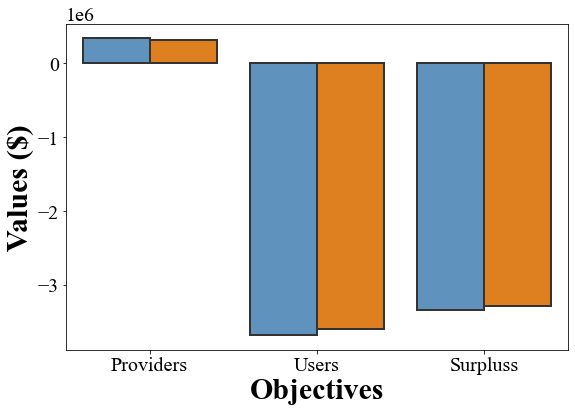

In [31]:
fig, ax = plt.subplots()
ax = sns.barplot(x='criteria', y='value', data=Results_df, hue= 'Type', linewidth=2, edgecolor=".2", palette = my_pal)
ax.set_xlabel("Objectives",**csfont)
ax.set_ylabel("Values (\$)",**csfont);
legend = plt.legend(fontsize=20, frameon=False);
ax.get_legend().remove()
plt.savefig('./Figures/EVPI.png',dpi=500, format='png', bbox_inches='tight')

In [32]:
Results_df

,criteria,value,Type
0,Providers,3.376746e+05,With anti
1,Providers,3.142806e+05,WO anti
2,Users,-3.680252e+06,With anti
3,Users,-3.596027e+06,WO anti
4,Surpluss,-3.342578e+06,With anti
5,Surpluss,-3.281746e+06,WO anti
